<a href="https://colab.research.google.com/github/nedelculiviu95/Kaggle-MNIST-using-Logistic-Regression/blob/master/CNN_DigitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pydicom

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(37800, 28, 28, 1)
(4200, 28, 28, 1)
(37800, 10)
(4200, 10)


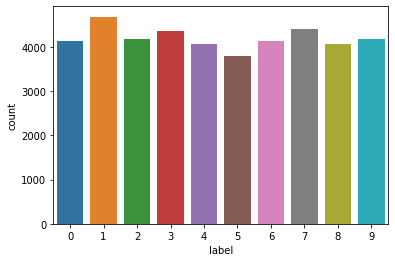

In [20]:
train = pd.read_csv("/content/gdrive/My Drive/DigitRecog/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/DigitRecog/test.csv")

Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)




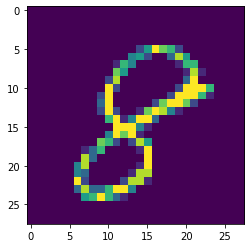

In [21]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [27]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)       

In [0]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [29]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 1115
IMAGE_SIZE = 28

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=batch_size)

Epoch 1/30
1115/1115 [==============================] - 251s 225ms/step - loss: 0.1106 - acc: 0.9704 - val_loss: 0.0324 - val_acc: 0.9940
Epoch 2/30
1115/1115 [==============================] - 252s 226ms/step - loss: 0.0242 - acc: 0.9936 - val_loss: 0.0846 - val_acc: 0.9881
Epoch 3/30
1115/1115 [==============================] - 251s 225ms/step - loss: 0.0184 - acc: 0.9953 - val_loss: 0.0346 - val_acc: 0.9952
Epoch 4/30
1115/1115 [==============================] - 249s 224ms/step - loss: 0.0154 - acc: 0.9962 - val_loss: 0.0432 - val_acc: 0.9950
Epoch 5/30
1115/1115 [==============================] - 250s 224ms/step - loss: 0.0136 - acc: 0.9968 - val_loss: 0.0393 - val_acc: 0.9936
Epoch 6/30
1115/1115 [==============================] - 248s 223ms/step - loss: 0.0124 - acc: 0.9971 - val_loss: 0.0563 - val_acc: 0.9929
Epoch 7/30
1115/1115 [==============================] - 248s 223ms/step - loss: 0.0110 - acc: 0.9974 - val_loss: 0.0481 - val_acc: 0.9952
Epoch 8/30
1115/1115 [============

In [0]:
results = model.predict(test)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("/content/gdrive/My Drive/DigitRecog/cnn_mnist_datagen.csv",index=False)

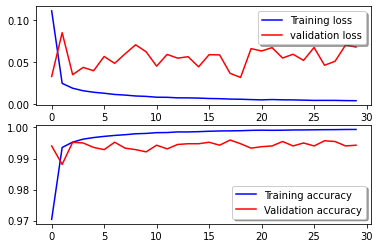

In [33]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Model:
#### In -> [[Conv2D->relu] * 2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out 
###records a 99.328 accuracy on test data.

### Model:
#### In -> [Conv2D->relu] * 3 -> BatchNorm -> MaxPool2D -> [Conv2D->relu] * 3 -> MaxPooling -> Flatten -> Dense -> Dropout -> Out 
###records a 0.99428 accuracy on test data.